In [117]:

# In a Jupyter Notebook cell
%load_ext autoreload
%autoreload 2

import numpy as np

from mirage import WordCountingChunkingAlgorithm, FolderRawStorage, SQLiteChunkStorage, RAMChunkStorage
from mirage import HuggingFaceEmbedder, TextNormalizer, BowEmbedder
from mirage import NatashaSentenceChunking, SemanticChunking
from mirage import FaissIndexFlatL2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import logging
logging.basicConfig(level=logging.ERROR)


documents = FolderRawStorage('../data_test')
chunks = RAMChunkStorage()

algorithm = NatashaSentenceChunking(raw_storage=documents, chunk_storage=chunks, sentences_in_chunk=1)
algorithm.execute(visualize=True)

1

In [119]:
emb = HuggingFaceEmbedder(normalizer = True, model_name='Alibaba-NLP/gte-large-en-v1.5')
emb.fit(chunks)
emb.get_dimensionality()

1024

In [120]:
vector_index = FaissIndexFlatL2(dimensionality=emb.get_dimensionality())
emb.convert_chunks_to_vector_index(chunks, vector_index, visualize=True)

Converting ChunkStorage to VectorIndex


100%|██████████| 28/28 [00:41<00:00,  1.48s/it]


In [121]:
import json 

path = '../benchmark/QnA/'
benchmarks = []

for p in os.listdir(path):
    
    with open(path+p, 'r', encoding='utf-8') as bench:
        benchmarks.append(json.load(bench))

In [128]:
os.listdir(path)

['05b257686f3d6de816d7dddca3d8f57f8664dfbf.json',
 '0a4bf58fddd5217dd59fe4745625d6f210e78933.json',
 '1124a091b19d2d65af973e5d746178bde7040ea7.json',
 '1cdefdec84e7af71afb3411b90fe182526dfbe89.json',
 '38cffc0daa9cd352f25022017358300a006dfcb0.json',
 '3c333a1896d4c5488730c3ed006636e951cb74f3.json',
 '3e2e41bd4b1789e812a75a130a55cdd26c8e6c89.json',
 '3ebe0752a720ccde058167dcfb8bf6423ebe1acb.json',
 '4c277e63d1a10ab20cfc08b757efb2300d430273.json',
 '52b1784797088460ad26e109cd2ab6741dce0040.json',
 '608e61359b3f171743de8af70324f1a0e38cbf24.json',
 '687af6709d98d4223fd48e92db7f8e3190d4c263.json',
 '6e3a5cec7dc8e1b2648156e7878f5ee0552e6835.json',
 '779d7348c1ffd41c35c1e9831e9aea4fedcaa3f4.json',
 '7b42b7e455f72c82d3c5a9de8e970d3a3ceb79db.json',
 '7c620c28c2f97e2b6d643bc16c0745c5b1b3ed25.json',
 '8f09b49d917771f6f2894c90c00029a3fa636c6a.json',
 '990537108b7a93132e78ee1abaafe95b9942f77c.json',
 'a4c1749bb374bbe410dfeeb15c54da198c54564c.json',
 'c18513dd4de81e48d061af9f14eac2679249ce23.json',


In [122]:
bow_embedder = BowEmbedder(normalizer=True)
bow_embedder.fit(chunks=chunks)
def bow_score(str1, str2):
    v1 = bow_embedder.embed(str1).reshape(1, -1)
    v2 = bow_embedder.embed(str2).reshape(1, -1)
    return euclidean_distances(v1, v2)[0][0]

In [123]:
bow_embedder.get_dimensionality()

351

In [124]:
def get_chunks(query: str):
    query_vector = emb.embed(text=query)
    answer = vector_index.query(query_vector, top_k=1)
    return " ".join([chunks[element.chunk_storage_key] for element in answer])

scores = []
for b in  benchmarks:
    chunk_real = b['ideal_context']
    chunk_model = get_chunks(b['question'])
    scores.append(bow_score(chunk_model, chunk_real))
scores

[21.236760581595302,
 152.22680447279973,
 43.22036556994862,
 22.9128784747792,
 28.053520278211074,
 29.086079144497972,
 28.089143810376278,
 20.97617696340303,
 26.324893162176366,
 46.281745861624536,
 48.55924216871593,
 145.59876373101525,
 23.83275057562597,
 20.346989949375804,
 152.22680447279973,
 26.324893162176366,
 23.45207879911715,
 23.83275057562597,
 154.7966407904254,
 26.962937525425527,
 20.346989949375804,
 48.55924216871593,
 154.26600403199663,
 46.281745861624536,
 24.310491562286437]

In [125]:
import pandas as pd
df = pd.Series(scores)


In [126]:
df.describe()

count     25.000000
mean      54.324268
std       50.600909
min       20.346990
25%       23.832751
50%       28.053520
75%       48.559242
max      154.796641
dtype: float64

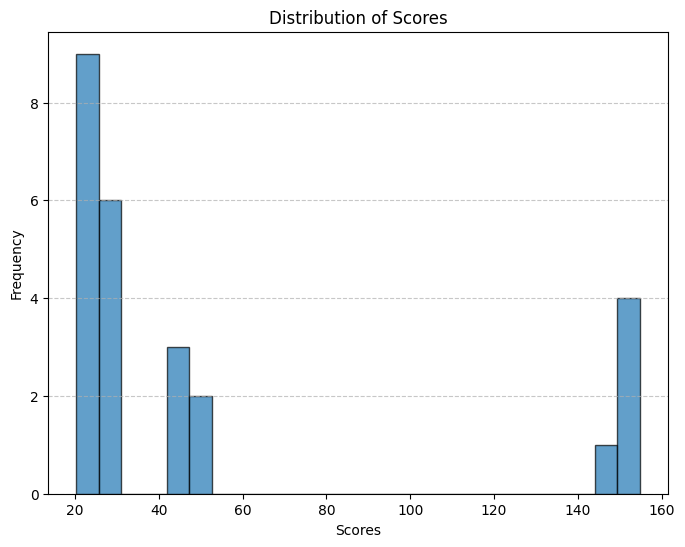

In [127]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(df, bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()